
# Exploring Voice Capture Ngrams


Based on [hands-on-nltk-tutorial by hb20007](https://github.com/hb20007/hands-on-nltk-tutorial)


## 0. Importing libraries and FRVRS logs data frame and creating helper tokenize method

In [1]:

%pprint
import sys
sys.path.insert(1, '../py')

Pretty printing has been turned OFF


In [2]:

%matplotlib inline
from nltk import ngrams, FreqDist, word_tokenize
from notebook_utils import NotebookUtilities
from numpy import arange
import matplotlib.pyplot as plt
import numpy as np
import operator
import os
import random
import string

# Get all CSVs into one data frame
nu = NotebookUtilities(data_folder_path=os.path.abspath('../data'))
if nu.pickle_exists('frvrs_logs_df'):
    frvrs_logs_df = nu.load_object('frvrs_logs_df')
    print(frvrs_logs_df.shape)
    # df = frvrs_logs_df.sample(4).dropna(axis='columns', how='all')
    # display(df.T)

(842663, 112)


In [3]:

def ultimate_tokenize(sentence):
    
    # Remove punctuation and digits
    sentence = sentence.translate(str.maketrans('', '', string.punctuation + string.digits))
    
    return word_tokenize(sentence.lower())

## 1. Understanding the process

In [4]:

def show_corpus_stats(sents_list):
    sent_count = len(sents_list)
    
    # Calculate the average word length
    word_ave = np.mean([len(word) for sent in sents_list for word in sent])
    
    print(f'The voice capture corpus contains {sent_count:,} sentences with an average of {word_ave:0.2} words each.')

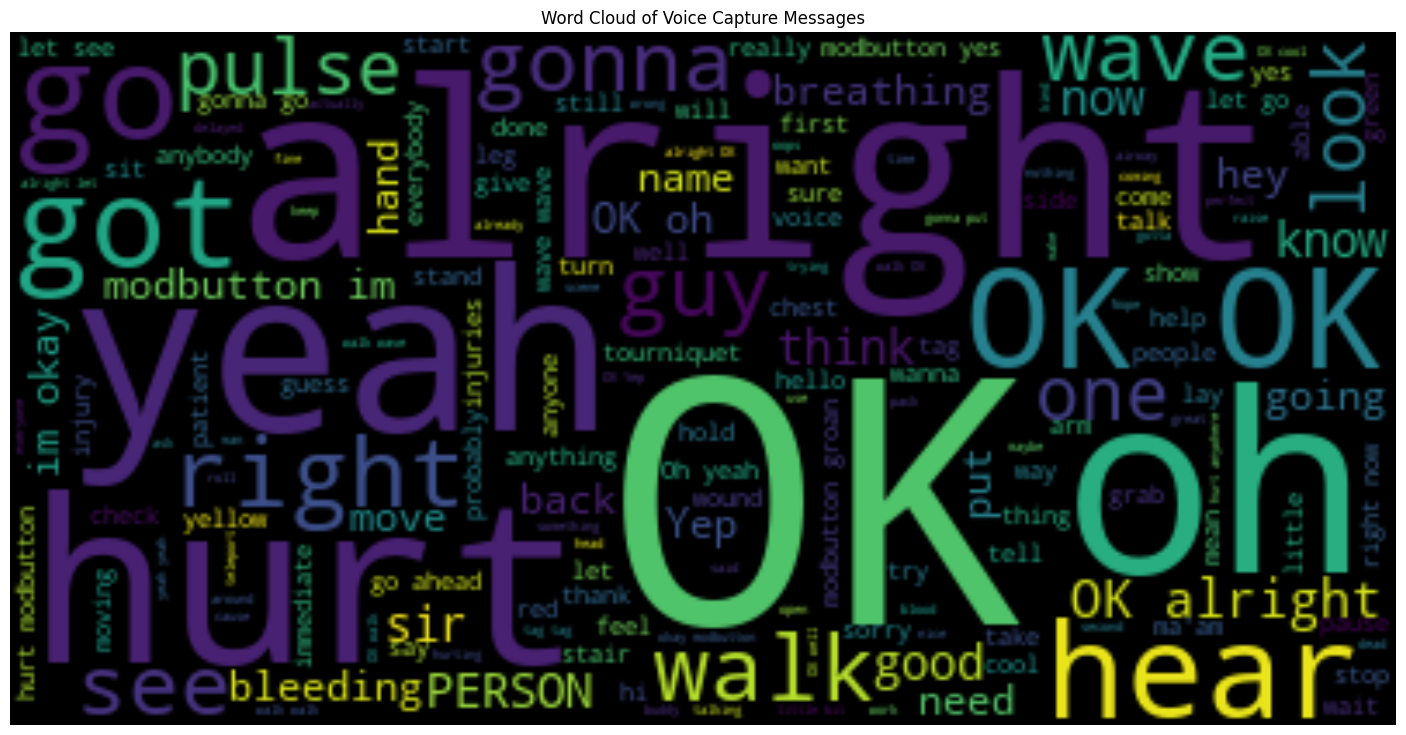

In [6]:

from wordcloud import WordCloud

# Flatten the list of lists of words
mask_series = (frvrs_logs_df.action_type == 'VOICE_CAPTURE')
voice_capture_words_list_list = frvrs_logs_df[mask_series].voice_capture_message.tolist()
voice_capture_words_list = []
for voice_capture_words in voice_capture_words_list_list:
    voice_capture_words_list += voice_capture_words.split()

# Create a word cloud object
wordcloud = WordCloud(max_font_size=100, max_words=200).generate(' '.join(voice_capture_words_list))

# Plot the word cloud
plt.figure(figsize=(18, 9))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of Voice Capture Messages')
plt.show()

In [7]:

[cn for cn in frvrs_logs_df.columns if 'voice' in cn]

['voice_capture_message', 'voice_capture_command_description', 'voice_command_message', 'voice_command_command_description', 'voice_capture_sentiment_score']

count    24218.000000
mean         0.094634
std          0.306805
min         -0.931300
25%          0.000000
50%          0.000000
75%          0.296000
max          0.988400
Name: voice_capture_sentiment_score, dtype: float64

voice_capture_sentiment_score
(-0.00984, 0.00935]    10442
(0.278, 0.297]          2698
(0.432, 0.451]          1553
(-0.528, -0.509]        1477
(0.24, 0.259]           1177
                       ...  
(-0.855, -0.835]           2
(-0.874, -0.855]           2
(-0.912, -0.893]           1
(-0.934, -0.912]           1
(-0.893, -0.874]           0
Name: count, Length: 100, dtype: int64

<Axes: >

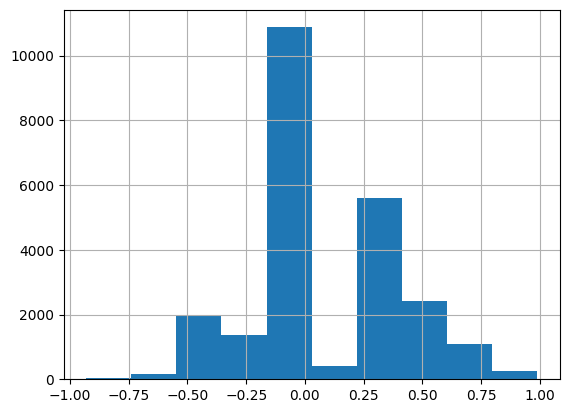

In [15]:

# Filter out anything after 16 minutes per Nicholas Kman
mask_series = (frvrs_logs_df.scene_type == 'Triage') & (frvrs_logs_df.is_scene_aborted == False)
df = frvrs_logs_df[mask_series]
display(df.voice_capture_sentiment_score.describe())
display(df.voice_capture_sentiment_score.value_counts(bins=100))

df.voice_capture_sentiment_score.hist()

In [5]:

mask_series = (frvrs_logs_df.action_type == 'VOICE_CAPTURE')
df = frvrs_logs_df[mask_series]
# display(df.sample(min(4, df.shape[0])).dropna(axis='columns', how='all').T)
# voice_capture_text = '\n'.join(df.voice_capture_message)

voice_capture_tokens_words = [ultimate_tokenize(x) for x in df.voice_capture_message]
show_corpus_stats(voice_capture_tokens_words)

The voice capture corpus contains 34,310 sentences with an average of 3.7 words each.


In [6]:

voice_capture_tokens_chars = list(voice_capture_tokens_words[0][0])
voice_capture_tokens_chars

['s', 'e', 't']

In [7]:

voice_capture_tokens_words_unigrams = [list(ngrams(x, 1)) for x in voice_capture_tokens_words]
for x in voice_capture_tokens_words_unigrams[0]:
    print(x)

('set',)
('lay',)
('down',)


In [8]:

voice_capture_tokens_words_bigrams = [
    list(
        ngrams(x, 2, pad_left=True, pad_right=True, left_pad_symbol='_', right_pad_symbol='_')
    ) for x in voice_capture_tokens_words
]
for x in voice_capture_tokens_words_bigrams[0]:
    print(x)

('_', 'set')
('set', 'lay')
('lay', 'down')
('down', '_')


In [9]:

unigram_freqdists_list = [FreqDist(x) for x in voice_capture_tokens_words_unigrams]
for freqdist_obj in unigram_freqdists_list:
    freqdist_obj.pprint()
    break

FreqDist({('set',): 1, ('lay',): 1, ('down',): 1})


In [10]:

bigram_freqdists_list = [FreqDist(x) for x in voice_capture_tokens_words_bigrams]
for freqdist_obj in bigram_freqdists_list:
    freqdist_obj.pprint()
    break

FreqDist({('_', 'set'): 1, ('set', 'lay'): 1, ('lay', 'down'): 1, ('down', '_'): 1})


In [11]:

unigram_dict = dict()
for freqdist_obj in unigram_freqdists_list:
    for k, v in freqdist_obj.items():
        k = ' '.join(k)
        if k in unigram_dict: v += unigram_dict[k]
        unigram_dict[k] = v

# Display a sub-dictionary with a number of random keys and their values
nu.get_random_subdictionary(unigram_dict)

{'pregnant': 3, 'reset': 3, 'extreme': 1, 'thought': 42, 'to': 2964}

In [12]:

bigram_dict = dict()
for freqdist_obj in bigram_freqdists_list:
    for k, v in freqdist_obj.items():
        k = ' '.join(k)
        if k in bigram_dict: v += bigram_dict[k]
        bigram_dict[k] = v

# Display a sub-dictionary with a number of random keys and their values
nu.get_random_subdictionary(bigram_dict)

{'dies eventually': 1, 'blurry good': 1, 'take then': 1, 'second and': 3, 'her tag': 1}

In [13]:

unigram_freqs = sorted(unigram_dict.items(), key=operator.itemgetter(1), reverse=True)
unigram_freqs[:10]

[('ok', 8152), ('you', 7998), ('i', 4813), ('can', 3513), ('to', 2964), ('the', 2801), ('oh', 2713), ('alright', 2643), ('that', 2558), ('so', 2552)]

In [14]:

bigram_freqs = sorted(bigram_dict.items(), key=operator.itemgetter(1), reverse=True)
bigram_freqs[:10]

[('_ ok', 5208), ('ok _', 4823), ('are you', 2078), ('_ oh', 2008), ('_ alright', 1902), ('_ are', 1747), ('you hurt', 1674), ('hurt _', 1642), ('_ modbutton', 1434), ('gon na', 1423)]

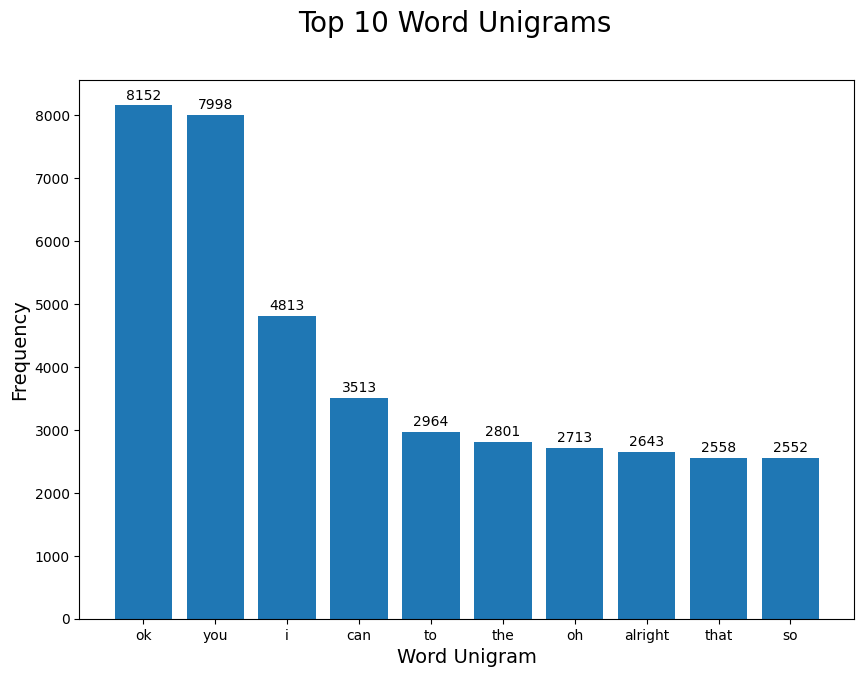

In [15]:

labels, values = zip(*unigram_freqs[:10])
indexes = arange(len(labels))
width = 0.8 # width = 1 would give bars that overlap because they are too close.

fig = plt.figure(figsize=(10,7))                                                               
ax = fig.gca() # Get current axis
rects = ax.bar(indexes, values, width)

# Add title and axis labels
fig.suptitle('Top 10 Word Unigrams', fontsize=20)
plt.xlabel('Word Unigram', fontsize=14)
plt.ylabel('Frequency', fontsize=14)

# Display value of each bar on bar
for rect in rects:
        height = rect.get_height()
        ax.text(rect.get_x() + rect.get_width() / 2., 50 + height, '%d' % int(height), ha='center', va='bottom') # Can also add color and fontweight arguments.

# Remove the default x-axis tick numbers and use tick numbers of your own choosing:
ax.set_xticks(indexes)
# Replace the tick numbers with strings:
ax.set_xticklabels(labels)

plt.show()
# plt.savefig('top10EnglishWordUnigrams.png')

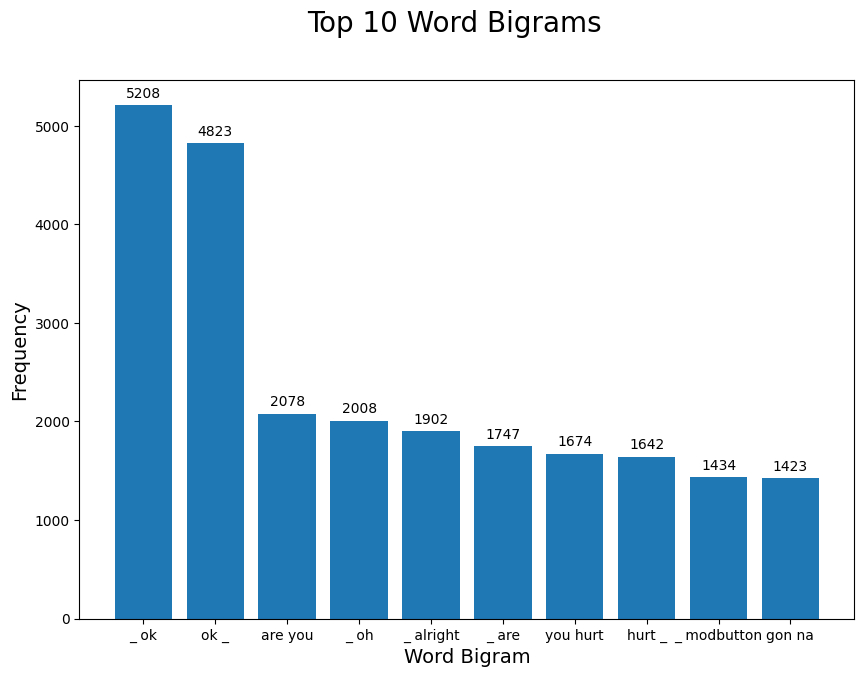

In [16]:

labels, values = zip(*bigram_freqs[:10])
indexes = arange(len(labels))
width = 0.8 # width = 1 would give bars that overlap because they are too close.

fig = plt.figure(figsize=(10,7))                                                               
ax = fig.gca() # Get current axis
rects = ax.bar(indexes, values, width)

# Add title and axis labels
fig.suptitle('Top 10 Word Bigrams', fontsize=20)
plt.xlabel('Word Bigram', fontsize=14)
plt.ylabel('Frequency', fontsize=14)

# Display value of each bar on bar
for rect in rects:
        height = rect.get_height()
        ax.text(rect.get_x() + rect.get_width() / 2., 50 + height, '%d' % int(height), ha='center', va='bottom') # Can also add color and fontweight arguments.

# Remove the default x-axis tick numbers and use tick numbers of your own choosing:
ax.set_xticks(indexes)
# Replace the tick numbers with strings:
ax.set_xticklabels(labels)

plt.show()
# plt.savefig('top10EnglishWordBigrams.png')


# Finding Unusual Words


Based on [hands-on-nltk-tutorial by hb20007](https://github.com/hb20007/hands-on-nltk-tutorial)


## 1. Importing and exploring the words corpus

In [17]:

from nltk.corpus import words

words.readme().replace('\n', ' ')

'Wordlists  en: English, http://en.wikipedia.org/wiki/Words_(Unix) en-basic: 850 English words: C.K. Ogden in The ABC of Basic English (1932) '

In [18]:

words

<WordListCorpusReader in 'C:\\Users\\DaveBabbitt\\AppData\\Roaming\\nltk_data\\corpora\\words'>

In [19]:

words.fileids()

['en', 'en-basic']

In [20]:

random.sample(words.words('en'), 10)

['overempired', 'inerrably', 'duotone', 'detonable', 'salenixon', 'schizothoracic', 'depigmentation', 'Perakim', 'persecutor', 'coniform']

In [21]:

random.sample(words.words('en-basic'), 10)

['desire', 'building', 'forward', 'ear', 'dog', 'only', 'force', 'cough', 'feeble', 'of']

In [22]:

len(words.words('en'))

235886

In [23]:

len(words.words('en-basic'))

850


## 2. Tokenizing text

In [24]:

from nltk import word_tokenize

words_list = [w for s in df.voice_capture_message for w in s.split()]
text_tokenized = word_tokenize(' '.join(words_list))
print(f'The voice capture corpus contains {len(text_tokenized):,} words.')
random.sample(text_tokenized, 10)

The voice capture corpus contains 183,588 words.


['green', 'over', 'but', 'you', 'me', 'move', 'oh', 'have', 'respiratory', 'you']

## 3. Finding unusual words

In [25]:

words_list = [w.lower() for w in text_tokenized if w.isalpha()]
print(f'The voice capture corpus contains a set of {len(set(words_list)):,} unpunctuated tokens.')
text_vocab = set(random.sample(words_list, 320))
english_vocab = set(w.lower() for w in words.words())
print(f'The English vocabulary contains a set of {len(english_vocab):,} unpunctuated tokens.')
text_vocab - english_vocab

The voice capture corpus contains a set of 3,472 unpunctuated tokens.
The English vocabulary contains a set of 234,377 unpunctuated tokens.


{'polls', 'modbutton', 'spurting', 'armbian', 'injuries', 'joystick', 'guys', 'looks', 'im'}

In [26]:

random.sample([w.lower() for w in words.words()], 10)

['sphincterismus', 'addability', 'reverend', 'bisley', 'isoxazole', 'legative', 'phantomizer', 'filipinize', 'prionidae', 'tutorless']

In [27]:

# Note .isalpha() removes punctuation tokens.
# However, tokens with a hyphen like 'browser-based' are totally skipped over because .isalpha() would be false.
english_vocab = set(w.lower() for w in words.words())
text_vocab = set(words_list)
unusual_set = text_vocab - english_vocab
print(f'The Unusual Set contains a set of {len(unusual_set):,} unpunctuated tokens.')
unusual_dict = {}
for word in unusual_set:
    if word in unigram_dict:
        # print(word, unigram_dict[word])
        unusual_dict[word] = unigram_dict[word]
unusual_freqs = sorted(unusual_dict.items(), key=operator.itemgetter(1), reverse=True)
unusual_freqs[:10]

The Unusual Set contains a set of 813 unpunctuated tokens.


[('im', 1769), ('modbutton', 1434), ('okay', 389), ('looks', 325), ('injuries', 238), ('guys', 215), ('stairs', 172), ('gotcha', 165), ('has', 162), ('pulses', 101)]


# Parts of Speech and Meaning

## 1. Tokenization

In [28]:

from nltk import sent_tokenize, word_tokenize

sentences_list = [sent_tokenize(t.lower()) for t in df.voice_capture_message]
random.sample(sentences_list, 10)

[['ok'], ['what you just say'], ['wave'], ['stay here'], ['patients'], ['alrighty then'], ['alright'], ['modbutton no'], ['ok'], ['.']]

In [29]:

sentences_list[2]

['so you know i would walk in see those four patients i would go and say if anybody can hear me i want you to wlk over here ok']

In [30]:

text = sentences_list[2][0]
display(text)
tokens = word_tokenize(text, language='english', preserve_line=True)
tokens

'so you know i would walk in see those four patients i would go and say if anybody can hear me i want you to wlk over here ok'

['so', 'you', 'know', 'i', 'would', 'walk', 'in', 'see', 'those', 'four', 'patients', 'i', 'would', 'go', 'and', 'say', 'if', 'anybody', 'can', 'hear', 'me', 'i', 'want', 'you', 'to', 'wlk', 'over', 'here', 'ok']

## 2. POS Tagging

In [31]:

from nltk import pos_tag

tags = pos_tag(tokens)
tags

[('so', 'RB'), ('you', 'PRP'), ('know', 'VBP'), ('i', 'RB'), ('would', 'MD'), ('walk', 'VB'), ('in', 'IN'), ('see', 'NN'), ('those', 'DT'), ('four', 'CD'), ('patients', 'NNS'), ('i', 'NN'), ('would', 'MD'), ('go', 'VB'), ('and', 'CC'), ('say', 'VB'), ('if', 'IN'), ('anybody', 'NN'), ('can', 'MD'), ('hear', 'VB'), ('me', 'PRP'), ('i', 'JJ'), ('want', 'VBP'), ('you', 'PRP'), ('to', 'TO'), ('wlk', 'VB'), ('over', 'IN'), ('here', 'RB'), ('ok', 'JJ')]

To access documentation for tags, for example for `NN`:

In [32]:

import nltk.help

nltk.help.upenn_tagset('NN')

NN: noun, common, singular or mass
    common-carrier cabbage knuckle-duster Casino afghan shed thermostat
    investment slide humour falloff slick wind hyena override subhumanity
    machinist ...


## 3. Word senses (for homonyms)

WordNet is a lexical database for the English language in the form of a semantic graph. 

WordNet groups English words into sets of synonyms called synsets, provides short definitions and usage examples, and records a number of relations among these synonym sets or their members.

NLTK provides an interface to the WordNet API.

In [33]:

from nltk.corpus import wordnet as wn

wn.synsets('patient')

[Synset('patient.n.01'), Synset('affected_role.n.01'), Synset('patient.a.01')]

In [34]:

wn.synsets('patient')[0].definition()

'a person who requires medical care'

In [35]:

wn.synsets('patient')[1].definition()

'the semantic role of an entity that is not the agent but is directly involved in or affected by the happening denoted by the verb in the clause'

In [36]:

patient = wn.synsets('patient', pos=wn.NOUN)[0]
patient

Synset('patient.n.01')

In [37]:

# A hypernym is a word with a broad meaning constituting a
# category into which words with more specific meanings fall;
# a superordinate. For example, colour is a hypernym of red.
patient.hypernyms()

[Synset('case.n.06'), Synset('sick_person.n.01')]

In [38]:

patient.hyponyms()

[Synset('alexic.n.01'), Synset('analysand.n.01'), Synset('arthritic.n.01'), Synset('hypertensive.n.01'), Synset('hypochondriac.n.01'), Synset('hypotensive.n.01'), Synset('index_case.n.01'), Synset('inpatient.n.01'), Synset('outpatient.n.01'), Synset('vaccinee.n.01')]

In [39]:

unigram_freqs

[('ok', 8152), ('you', 7998), ('i', 4813), ('can', 3513), ('to', 2964), ('the', 2801), ('oh', 2713), ('alright', 2643), ('that', 2558), ('so', 2552), ('are', 2407), ('me', 2315), ('a', 2248), ('and', 2225), ('it', 1870), ('this', 1866), ('is', 1830), ('go', 1819), ('hurt', 1813), ('yeah', 1809), ('your', 1778), ('im', 1769), ('there', 1739), ('na', 1622), ('wave', 1593), ('walk', 1569), ('no', 1537), ('here', 1512), ('on', 1467), ('modbutton', 1434), ('gon', 1423), ('do', 1411), ('got', 1265), ('right', 1243), ('if', 1207), ('like', 1134), ('just', 1076), ('hear', 1072), ('see', 1040), ('we', 1002), ('over', 993), ('have', 919), ('hes', 907), ('thats', 894), ('what', 858), ('not', 851), ('youre', 820), ('dont', 787), ('pulse', 775), ('its', 757), ('of', 749), ('my', 745), ('for', 728), ('then', 711), ('in', 709), ('up', 708), ('get', 694), ('be', 691), ('good', 660), ('him', 646), ('one', 643), ('he', 624), ('yes', 609), ('now', 586), ('well', 580), ('at', 579), ('person', 565), ('sir'

In [40]:

wave = wn.synsets('wave')[0]
wave

Synset('wave.n.01')

In [41]:

walk = wn.synsets('walk')[1]
walk

Synset('base_on_balls.n.01')

In [42]:

# The Wu-Palmer metric (WUP) is a measure of similarity
# based on distance in the graph.
# There are many other metrics too.
wave.wup_similarity(patient)

0.15384615384615385

In [43]:

walk.wup_similarity(patient)

0.14285714285714285

In [44]:

# A lemma is basically the dictionary form or base form of a word,
# as opposed to the various inflected forms of a word. 
synonyms_set = set()
for syn in wn.synsets('walk'):
    for lemma in syn.lemmas():
        synonyms_set.add(lemma.name())
synonyms_set

{'walkway', 'walking', 'walk', 'manner_of_walking', 'base_on_balls', 'walk_of_life', 'pass', 'paseo', 'take_the_air'}

In [45]:

antonyms_set = set()
for syn in wn.synsets('walk'):
    for l in syn.lemmas():
        if l.antonyms():
            antonyms_set.add(l.antonyms()[0].name())
antonyms_set

{'ride'}

## 4. Chunking and Entity Recognition

The goal of chunking is to divide a sentence into chunks. Usually each chunk contains a **head** and optionally additionally words and modifiers. Examples of chunks include noun groups and verb groups.

### 4.1. Chunking

In [46]:

from nltk.chunk import RegexpParser

In order to create a chunker, we need to first define a **chunk grammar**, consisting of rules that indicate how sentences should be chunked. 

We can define a simple grammar for a noun phrase (NP) chunker with a single regular-expression rule. This rule says that an NP chunk should be formed whenever the chunker finds an optional determiner (`DT`) followed by any number of adjectives (`JJ`) and then a noun (`NN`).

Note how grammatical structures which are not noun phrases are not chunked, which is totally fine:

In [47]:

grammar = 'NP: {<DT>?<JJ>*<NN>}'

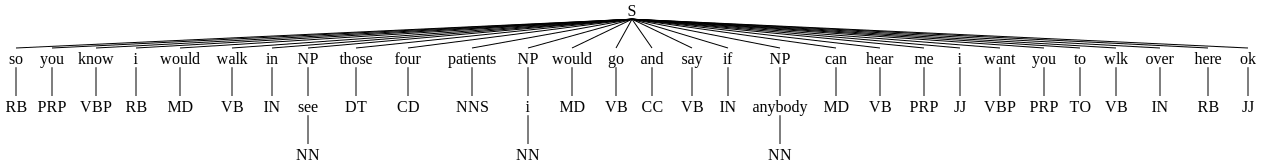

In [48]:

chunker = RegexpParser(grammar)
result = chunker.parse(tags)
result

In [49]:

display(type(result))
dir(result)

<class 'nltk.tree.tree.Tree'>

['__add__', '__class__', '__class_getitem__', '__contains__', '__copy__', '__deepcopy__', '__delattr__', '__delitem__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__getitem__', '__gt__', '__hash__', '__iadd__', '__imul__', '__init__', '__init_subclass__', '__iter__', '__le__', '__len__', '__lt__', '__module__', '__mul__', '__ne__', '__new__', '__radd__', '__reduce__', '__reduce_ex__', '__repr__', '__reversed__', '__rmul__', '__setattr__', '__setitem__', '__sizeof__', '__str__', '__subclasshook__', '__weakref__', '_frozen_class', '_get_node', '_label', '_parse_error', '_pformat_flat', '_repr_svg_', '_set_node', 'append', 'chomsky_normal_form', 'clear', 'collapse_unary', 'convert', 'copy', 'count', 'draw', 'extend', 'flatten', 'freeze', 'fromlist', 'fromstring', 'height', 'index', 'insert', 'label', 'leaf_treeposition', 'leaves', 'node', 'pformat', 'pformat_latex_qtree', 'pop', 'pos', 'pprint', 'pretty_print', 'productions', 'remove', 'revers

In [50]:

result.pprint()

(S
  so/RB
  you/PRP
  know/VBP
  i/RB
  would/MD
  walk/VB
  in/IN
  (NP see/NN)
  those/DT
  four/CD
  patients/NNS
  (NP i/NN)
  would/MD
  go/VB
  and/CC
  say/VB
  if/IN
  (NP anybody/NN)
  can/MD
  hear/VB
  me/PRP
  i/JJ
  want/VBP
  you/PRP
  to/TO
  wlk/VB
  over/IN
  here/RB
  ok/JJ)


### 4.2. Entity Recognition

The goal of entity recogintion is to detect entities such as Person, Location, Time, etc.

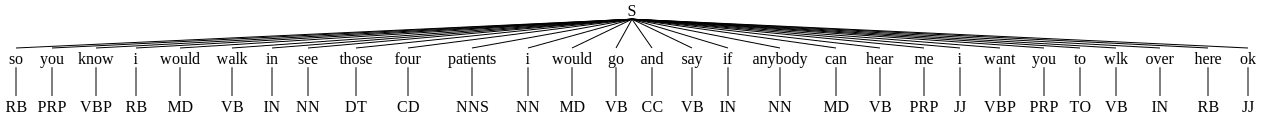

In [51]:

# ne = named entity
from nltk.chunk import ne_chunk

result = ne_chunk(tags)
result


Note `ne_chunk` was unable to detect any entities in our sentence. That is because it is quite limited, being able to recognize only the following entities: 
> FACILITY, GPE (Geo-Political Entity), GSP (Geo-Socio-Political group), LOCATION, ORGANIZATION, PERSON 

In [52]:

result.pprint()

(S
  so/RB
  you/PRP
  know/VBP
  i/RB
  would/MD
  walk/VB
  in/IN
  see/NN
  those/DT
  four/CD
  patients/NNS
  i/NN
  would/MD
  go/VB
  and/CC
  say/VB
  if/IN
  anybody/NN
  can/MD
  hear/VB
  me/PRP
  i/JJ
  want/VBP
  you/PRP
  to/TO
  wlk/VB
  over/IN
  here/RB
  ok/JJ)


In [53]:

nltk.help.upenn_tagset('VBP')

VBP: verb, present tense, not 3rd person singular
    predominate wrap resort sue twist spill cure lengthen brush terminate
    appear tend stray glisten obtain comprise detest tease attract
    emphasize mold postpone sever return wag ...


# Sentiment Analysis

Based on *Exercise B: Sentiment Analysis* in [Natural Language Processing with Python/NLTK by Luciano M. Guasco](https://github.com/luchux/ipython-notebook-nltk/blob/master/NLP%20-%20MelbDjango.ipynb)

## 1. Exploring the `movie_reviews` corpus

In [54]:

# These are movie reviews already separated as positive and negative
from nltk.corpus import movie_reviews

movie_reviews.readme().replace('\n', ' ').replace('\t', '').replace('``', '"').replace("''", '"').replace('`', "'")

'Sentiment Polarity Dataset Version 2.0 Bo Pang and Lillian Lee  http://www.cs.cornell.edu/people/pabo/movie-review-data/  Distributed with NLTK with permission from the authors.  =======  Introduction  This README v2.0 (June, 2004) for the v2.0 polarity dataset comes from the URL http://www.cs.cornell.edu/people/pabo/movie-review-data .  =======  What\'s New -- June, 2004  This dataset represents an enhancement of the review corpus v1.0 described in README v1.1: it contains more reviews, and labels were created with an improved rating-extraction system.  =======  Citation Info   This data was first used in Bo Pang and Lillian Lee, "A Sentimental Education: Sentiment Analysis Using Subjectivity Summarization  Based on Minimum Cuts",  Proceedings of the ACL, 2004.  @InProceedings{Pang+Lee:04a,   author =       {Bo Pang and Lillian Lee},   title =        {A Sentimental Education: Sentiment Analysis Using Subjectivity Summarization Based on Minimum Cuts},   booktitle =    "Proceedings of 

In [55]:

random.sample(movie_reviews.fileids(), 10)

['neg/cv305_9937.txt', 'neg/cv434_5641.txt', 'pos/cv289_6463.txt', 'pos/cv347_13194.txt', 'neg/cv112_12178.txt', 'neg/cv896_17819.txt', 'neg/cv711_12687.txt', 'pos/cv720_5389.txt', 'pos/cv851_20469.txt', 'pos/cv213_18934.txt']

In [56]:

len(movie_reviews.fileids())

2000

In [57]:

# Note here I found a trick to get rid of \' in text. However it only works if there were no " used
movie_reviews.raw("neg/cv000_29416.txt").replace("\n", "").replace("'", '"').replace('"', "'")

"plot : two teen couples go to a church party , drink and then drive . they get into an accident . one of the guys dies , but his girlfriend continues to see him in her life , and has nightmares . what's the deal ? watch the movie and ' sorta ' find out . . . critique : a mind-fuck movie for the teen generation that touches on a very cool idea , but presents it in a very bad package . which is what makes this review an even harder one to write , since i generally applaud films which attempt to break the mold , mess with your head and such ( lost highway & memento ) , but there are good and bad ways of making all types of films , and these folks just didn't snag this one correctly . they seem to have taken this pretty neat concept , but executed it terribly . so what are the problems with the movie ? well , its main problem is that it's simply too jumbled . it starts off ' normal ' but then downshifts into this ' fantasy ' world in which you , as an audience member , have no idea what's

## 2. Building and testing the classifier

In [58]:

from nltk.corpus import stopwords

stops = stopwords.words('english')
stops.extend('.,[,],(,),;,/,-,\',?,",:,<,>,n\'t,|,#,\'s,\",\'re,\'ve,\'ll,\'d,\'re'.split(','))
stops.extend(',')
stops

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

In [59]:

# Utility functions and classes for classifiers. Contains functions such as accuracy(classifier, gold)
from nltk.classify import NaiveBayesClassifier
import nltk.classify.util

# Given a word, returns a dict {word: True}. This will be our feature in the classifier. 
def word_feats(words):
    return dict([(word, True) for word in words if word not in stops and word.isalpha()])

pos_ids = movie_reviews.fileids('pos')
neg_ids = movie_reviews.fileids('neg')

len(pos_ids) + len(neg_ids) 

2000

In [60]:

# We take the positive/negative words, create the feature for such words,
# and store it in a positive/negative features list
pos_feats = [(word_feats(movie_reviews.words(fileids=[f])), 'pos') for f in pos_ids]
neg_feats = [(word_feats(movie_reviews.words(fileids=[f])), 'neg') for f in neg_ids]

nu.get_random_subdictionary(pos_feats[0][0])

{'comparison': True, 'brothers': True, 'peaks': True, 'crimes': True, 'book': True}

In [61]:

# 3/4 of the features will be used for training.
pos_len_train = int(len(pos_feats) * 3 / 4)
neg_len_train = int(len(neg_feats) * 3 / 4)

pos_len_train

750

In [62]:

train_feats = neg_feats[:neg_len_train] + pos_feats[:pos_len_train]
test_feats = neg_feats[neg_len_train:] + pos_feats[pos_len_train:]

# Training a NaiveBayesClassifier with our training feature words.
classifier = NaiveBayesClassifier.train(train_feats)

print('Accuracy: ', nltk.classify.util.accuracy(classifier, test_feats))

Accuracy:  0.712


In [63]:

# We can see which words fit best in each class
classifier.show_most_informative_features()

Most Informative Features
             magnificent = True              pos : neg    =     15.0 : 1.0
             outstanding = True              pos : neg    =     13.6 : 1.0
               insulting = True              neg : pos    =     13.0 : 1.0
              vulnerable = True              pos : neg    =     12.3 : 1.0
               ludicrous = True              neg : pos    =     11.8 : 1.0
                  avoids = True              pos : neg    =     11.7 : 1.0
             uninvolving = True              neg : pos    =     11.7 : 1.0
              astounding = True              pos : neg    =     10.3 : 1.0
             fascination = True              pos : neg    =     10.3 : 1.0
                 idiotic = True              neg : pos    =      9.8 : 1.0


## 3. Classifying new data

In [64]:

from nltk import word_tokenize

def get_sentiment(sentence, verbose=True):
    if verbose: print(sentence)
    tokens = [word for word in word_tokenize(sentence) if word not in stops]
    if verbose: print(tokens)
    feats = word_feats(word for word in tokens)
    if verbose: print(feats)
    
    return classifier.classify(feats)

In [65]:

# sentence = "I feel so miserable, it makes me amazing"
sentence = sorted(df.voice_capture_message.tolist(), key=lambda x: len(x))[-1]
get_sentiment(sentence, verbose=True)

alright if you guys can hear my voice please walk over here to my voice if anybody sir if you can move please walk over here to my voice yeah please come over here and please stand over here by the stairs while until i can come back and take a look at you guys thank you yep everything's OK yep OK if anybody else can you raise your arm move your razor move your arm around if you can hear my voice so i can come see you
['alright', 'guys', 'hear', 'voice', 'please', 'walk', 'voice', 'anybody', 'sir', 'move', 'please', 'walk', 'voice', 'yeah', 'please', 'come', 'please', 'stand', 'stairs', 'come', 'back', 'take', 'look', 'guys', 'thank', 'yep', 'everything', 'OK', 'yep', 'OK', 'anybody', 'else', 'raise', 'arm', 'move', 'razor', 'move', 'arm', 'around', 'hear', 'voice', 'come', 'see']
{'alright': True, 'guys': True, 'hear': True, 'voice': True, 'please': True, 'walk': True, 'anybody': True, 'sir': True, 'move': True, 'yeah': True, 'come': True, 'stand': True, 'stairs': True, 'back': True, '

'neg'

In [66]:

sentence = sorted(df.voice_capture_message.tolist(), key=lambda x: len(x))[-2]
get_sentiment(sentence, verbose=True)

if you're going and you're walking to an unconscious patient and you see somebody that has their leg amputated and they're bleeding out you're gonna stop and put a tourniquet on them and say hey i'll be right back and then you're gonna go and continue on to that unconscious patient but in the program it's more black and white than that so don't don't worry about like having to jump over to another
['going', 'walking', 'unconscious', 'patient', 'see', 'somebody', 'leg', 'amputated', 'bleeding', 'gon', 'na', 'stop', 'put', 'tourniquet', 'say', 'hey', 'right', 'back', 'gon', 'na', 'go', 'continue', 'unconscious', 'patient', 'program', 'black', 'white', 'worry', 'like', 'jump', 'another']
{'going': True, 'walking': True, 'unconscious': True, 'patient': True, 'see': True, 'somebody': True, 'leg': True, 'amputated': True, 'bleeding': True, 'gon': True, 'na': True, 'stop': True, 'put': True, 'tourniquet': True, 'say': True, 'hey': True, 'right': True, 'back': True, 'go': True, 'continue': Tru

'pos'

## 4. Incorporating bigram features

In order to improve the classifier, bigram features can be examined using `nltk.util.ngrams`. This is because, for instance, 'not funny' is very different from 'funny'.

# Sentiment Analysis with `nltk.sentiment.SentimentAnalyzer` and VADER tools

## 1. Exploring the `subjectivity` corpus

In [67]:

from nltk.corpus import subjectivity

subjectivity.fileids()

['plot.tok.gt9.5000', 'quote.tok.gt9.5000']

In [68]:

subjectivity.sents('plot.tok.gt9.5000')

[['the', 'movie', 'begins', 'in', 'the', 'past', 'where', 'a', 'young', 'boy', 'named', 'sam', 'attempts', 'to', 'save', 'celebi', 'from', 'a', 'hunter', '.'], ['emerging', 'from', 'the', 'human', 'psyche', 'and', 'showing', 'characteristics', 'of', 'abstract', 'expressionism', ',', 'minimalism', 'and', 'russian', 'constructivism', ',', 'graffiti', 'removal', 'has', 'secured', 'its', 'place', 'in', 'the', 'history', 'of', 'modern', 'art', 'while', 'being', 'created', 'by', 'artists', 'who', 'are', 'unconscious', 'of', 'their', 'artistic', 'achievements', '.'], ...]

In [69]:

subjectivity.sents('quote.tok.gt9.5000')

[['smart', 'and', 'alert', ',', 'thirteen', 'conversations', 'about', 'one', 'thing', 'is', 'a', 'small', 'gem', '.'], ['color', ',', 'musical', 'bounce', 'and', 'warm', 'seas', 'lapping', 'on', 'island', 'shores', '.', 'and', 'just', 'enough', 'science', 'to', 'send', 'you', 'home', 'thinking', '.'], ...]

In [70]:

# The mapping between documents and categories does not depend on the file structure
subjectivity.categories()

['obj', 'subj']

In [71]:

subjectivity.sents(categories='obj')

[['the', 'movie', 'begins', 'in', 'the', 'past', 'where', 'a', 'young', 'boy', 'named', 'sam', 'attempts', 'to', 'save', 'celebi', 'from', 'a', 'hunter', '.'], ['emerging', 'from', 'the', 'human', 'psyche', 'and', 'showing', 'characteristics', 'of', 'abstract', 'expressionism', ',', 'minimalism', 'and', 'russian', 'constructivism', ',', 'graffiti', 'removal', 'has', 'secured', 'its', 'place', 'in', 'the', 'history', 'of', 'modern', 'art', 'while', 'being', 'created', 'by', 'artists', 'who', 'are', 'unconscious', 'of', 'their', 'artistic', 'achievements', '.'], ...]

In [72]:

subjectivity.sents(categories='subj')

[['smart', 'and', 'alert', ',', 'thirteen', 'conversations', 'about', 'one', 'thing', 'is', 'a', 'small', 'gem', '.'], ['color', ',', 'musical', 'bounce', 'and', 'warm', 'seas', 'lapping', 'on', 'island', 'shores', '.', 'and', 'just', 'enough', 'science', 'to', 'send', 'you', 'home', 'thinking', '.'], ...]

## 2. Building and testing a classifier with `SentimentAnalyzer`

In [73]:

from nltk.classify import NaiveBayesClassifier

# SentimentAnalyzer is a tool to implement and facilitate Sentiment Analysis
from nltk.sentiment import SentimentAnalyzer

# mark_negation(): Append _NEG suffix to words that appear in the scope
# between a negation and a punctuation mark. extract_unigram_feats():
# Populate a dictionary of unigram features, reflecting the presence/absence
# in the document of each of the tokens in unigrams
from nltk.sentiment.util import (mark_negation, extract_unigram_feats)

n_instances = 100
obj_docs = [(sent, 'obj') for sent in subjectivity.sents(categories='obj')[:n_instances]]
subj_docs = [(sent, 'subj') for sent in subjectivity.sents(categories='subj')[:n_instances]]
len(obj_docs), len(subj_docs)

(100, 100)

In [74]:

obj_docs[0]

(['the', 'movie', 'begins', 'in', 'the', 'past', 'where', 'a', 'young', 'boy', 'named', 'sam', 'attempts', 'to', 'save', 'celebi', 'from', 'a', 'hunter', '.'], 'obj')

In [75]:

train_obj_docs = obj_docs[:80]
test_obj_docs = obj_docs[80:100]
train_subj_docs = subj_docs[:80]
test_subj_docs = subj_docs[80:100]

training_docs = train_obj_docs + train_subj_docs
testing_docs = test_obj_docs + test_subj_docs

sentim_analyzer = SentimentAnalyzer()
all_words_neg = sentim_analyzer.all_words([mark_negation(doc) for doc in training_docs])

In [76]:

unigram_feats = sentim_analyzer.unigram_word_feats(all_words_neg, min_freq=4)
len(unigram_feats)

83

In [77]:

sentim_analyzer.add_feat_extractor(extract_unigram_feats, unigrams=unigram_feats)

In [78]:

training_set = sentim_analyzer.apply_features(training_docs)
test_set = sentim_analyzer.apply_features(testing_docs)
training_set_tuple = training_set[0]
(nu.get_random_subdictionary(training_set_tuple[0]), training_set_tuple[1])

({'contains(.)': True, 'contains(for)': False, 'contains(both)': False, 'contains(,)': False, 'contains(of)': False}, 'obj')

In [79]:

trainer = NaiveBayesClassifier.train
classifier = sentim_analyzer.train(trainer, training_set)

Training classifier


In [80]:

for key,value in sorted(sentim_analyzer.evaluate(test_set).items()):
    print('{0}: {1}'.format(key, value))

Evaluating NaiveBayesClassifier results...
Accuracy: 0.8
F-measure [obj]: 0.8
F-measure [subj]: 0.8
Precision [obj]: 0.8
Precision [subj]: 0.8
Recall [obj]: 0.8
Recall [subj]: 0.8


## 3. Sentiment analysis with `nltk.sentiment.vader.SentimentIntensityAnalyzer`

In [81]:

from nltk.sentiment.vader import SentimentIntensityAnalyzer

sentences = np.random.choice(df.voice_capture_message.unique(), 5)
sid = SentimentIntensityAnalyzer()
for sentence in sentences:
    print('\n' + sentence)
    ss = sid.polarity_scores(sentence)
    for k in sorted(ss):
        print('{0}: {1}, '.format(k, ss[k]), end='')


alright i'm giving you this sir do you have any injuries
compound: 0.5267, neg: 0.0, neu: 0.672, pos: 0.328, 
to a different area that's safer
compound: 0.4215, neg: 0.0, neu: 0.588, pos: 0.412, 
his stomach OK airways intact
compound: 0.5766, neg: 0.0, neu: 0.388, pos: 0.612, 
not what I wanted
compound: 0.0, neg: 0.0, neu: 1.0, pos: 0.0, 
then we kind of explain what each of the things is
compound: 0.0, neg: 0.0, neu: 1.0, pos: 0.0, 

In [82]:

mask_series = frvrs_logs_df.voice_capture_message.isnull()
df1 = frvrs_logs_df[~mask_series]
display(df1.sample(min(4, df1.shape[0])).dropna(axis='columns', how='all').T)

,790367,784052,151095,770251
action_type,VOICE_CAPTURE,VOICE_CAPTURE,VOICE_CAPTURE,VOICE_CAPTURE
action_tick,315936,525816,122380,47456
event_time,2023-05-10 11:25:00,2023-05-11 10:27:00,2022-12-07 13:07:36,2023-06-12 14:30:00
session_uuid,d2c676e2-fddc-4872-9a26-b621d6585df9,c12f8355-5a14-4ccc-bde4-d8038cae9220,634a2340-066c-4993-a7be-a7ff0481b6b0,a0987257-801e-44c5-a1ad-81e0083bfa46
file_name,v.1.0/clean-d2c676e2-fddc-4872-9a26-b621d6585d...,v.1.0/clean-c12f8355-5a14-4ccc-bde4-d8038cae92...,All CSV files renamed by date/12.07.22.1315.csv,v.1.0/clean-a0987257-801e-44c5-a1ad-81e0083bfa...
logger_version,1.0,1.0,1.0,1.0
scene_index,2,2,1,0
voice_capture_message,alright anybody else that can hear me if you c...,are you hurt,i'm not trying to push the rest of the way in,yes I do
voice_capture_sentiment_score,0.6369,-0.5267,0.0,0.4019


In [83]:

df2 = df1.sort_values('voice_capture_sentiment_score').head(4)
print('\n'.join(df2.voice_capture_message))
display(df2.dropna(axis='columns', how='all').T)

that dictates the answers that they give based on the injuries but it doesn't do that for the other things so because her injuries are her ears she won't answer any question about her injury are you hurt ma'am are you hurt
no no no no no no no my other guy that I put the needle decompression I want him then the burn guy then the amputation this guy and then my gentleman right over here my minimal the last one
war chest trauma in addition to that that fight injury
so now you have stopped that life threatening hemorrhage he can actually be a delayed patient because we can leave targets on for quite a long time so he's a yellow if he had penetrating abdominal or chest trauma along with that extremity injury then he would be a red


,125580,842219,74655,15007
action_type,VOICE_CAPTURE,VOICE_CAPTURE,VOICE_CAPTURE,VOICE_CAPTURE
action_tick,117961,485707,313292,427432
event_time,2022-11-30 08:31:44,2023-09-07 14:56:58,2023-04-19 11:59:10,2023-03-10 10:13:50
session_uuid,5325cdbf-d627-4aba-b5b4-9a62240d599f,fde2c201-36fc-4123-bf42-f1bff1b24969,3228f729-d512-431a-bb96-d6f9aacb5d00,7e340eb0-fda8-4eea-addc-5f554be907a5
file_name,All CSV files renamed by date/11.30.22.0832.csv,v.1.3/fde2c201-36fc-4123-bf42-f1bff1b24969.csv,All CSV files renamed by date/04.19.23.1207.csv,All CSV files renamed by date/03.10.23.1007.csv
logger_version,1.0,1.3,1.3,1.3
scene_index,1,1,2,1
voice_capture_message,that dictates the answers that they give based...,no no no no no no no my other guy that I put t...,war chest trauma in addition to that that figh...,so now you have stopped that life threatening ...
voice_capture_command_description,NaN,NA,NA,NA
voice_capture_sentiment_score,-0.9313,-0.9022,-0.9022,-0.9001


In [84]:

df2 = df1.sort_values('voice_capture_sentiment_score').tail(4)
print('\n'.join(df2.voice_capture_message))
display(df2.dropna(axis='columns', how='all').T)

OK Yep it's OK I'm gonna help you alright just hang in there for a second I gotta get this tourniquet on you OK alright should I get rapid pulse OK you're gonna be OK alright we're gonna get you out here soon as we can get you on you
good good good good good good good good good
glory glory glory glory glory glory glory
ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha


,764468,738456,198132,183264
action_type,VOICE_CAPTURE,VOICE_CAPTURE,VOICE_CAPTURE,VOICE_CAPTURE
action_tick,445368,552093,434704,464931
event_time,2023-06-23 11:13:00,2023-05-11 10:54:00,2023-08-16 09:52:59,2023-08-09 10:17:09
session_uuid,926de73a-7764-4409-920e-b2416cb57f9b,4226ad6c-bb0a-4df0-8c4a-64c312927578,be877d11-14b3-432c-be4d-b3e0d236f6e1,693461dd-b8f6-4c60-92b6-bd1db0ffcac8
file_name,v.1.0/clean-926de73a-7764-4409-920e-b2416cb57f...,v.1.0/clean-4226ad6c-bb0a-4df0-8c4a-64c3129275...,DCEMS Round 2 only triage sessions/be877d11-14...,DCEMS Round 2 only triage sessions/693461dd-b8...
logger_version,1.0,1.0,1.0,1.0
scene_index,2,2,1,1
voice_capture_message,OK Yep it's OK I'm gonna help you alright just...,good good good good good good good good good,glory glory glory glory glory glory glory,ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha h...
voice_capture_sentiment_score,0.9704,0.9753,0.9764,0.9884


Above, `compound` represents the aggregated, final score.

# Word2Vec (gensim)

Based on [Dive Into NLTK, Part X: Play with Word2Vec Models based on NLTK Corpus by TextMiner](http://textminingonline.com/dive-into-nltk-part-x-play-with-word2vec-models-based-on-nltk-corpus)

## 2. Implementing Word2Vec

In [85]:

discard_punctuation_and_lowercased_sents = [[word.lower() for word in sent.split() if word not in string.punctuation and word.isalpha()] 
                                            for sent in df.voice_capture_message.unique()]
discard_punctuation_and_lowercased_sents[2]

['so', 'you', 'know', 'i', 'would', 'walk', 'in', 'see', 'those', 'four', 'patients', 'i', 'would', 'go', 'and', 'say', 'if', 'anybody', 'can', 'hear', 'me', 'i', 'want', 'you', 'to', 'wlk', 'over', 'here', 'ok']

In [86]:

from gensim.models import Word2Vec

word2vec_model = Word2Vec(discard_punctuation_and_lowercased_sents, min_count=5)
word2vec_model.save('../saves/word2vec/word2vec_gensim')
word_vectors = word2vec_model.wv
del word2vec_model # When we finish training the model, we can only delete it and keep the word vectors.
word_vectors.save_word2vec_format('../saves/word2vec/word2vec_org', '../saves/word2vec/word2vec_vocabulary')
len(word_vectors.index_to_key)

1079

In [87]:

# Most similar as in closest in the word graph.
# Word2vec is essentially about proportions of word occurrences
# in relations holding in general over large corpora of text.
# Consider word analogy ‘man is to woman as king is to X’
# which was famously demonstrated in word2vec.
# The algorithm is able to come up with an answer queen,
# almost magically by simple vector differences.
# The main idea, called distributional hypothesis,
# is that similar words appear in similar contexts of words around them
word_vectors.most_similar(['patient'])

[('sky', 0.9930479526519775), ('tutorial', 0.9928046464920044), ('last', 0.9917479753494263), ('salt', 0.991710364818573), ('line', 0.9916912913322449), ('shirt', 0.9909893274307251), ('program', 0.9908697605133057), ('joystick', 0.9904271960258484), ('whole', 0.9902134537696838), ('same', 0.9901471734046936)]

In [88]:

word_vectors.most_similar(['person'])

[('next', 0.9654101729393005), ('resource', 0.961746871471405), ('room', 0.9615195393562317), ('thing', 0.9581617712974548), ('pack', 0.9572541117668152), ('unconscious', 0.9569960832595825), ('responder', 0.9560369849205017), ('straight', 0.9554514288902283), ('tutorial', 0.9553431272506714), ('one', 0.9550454616546631)]

In [89]:

word_vectors.most_similar(['sit'], topn=3)

[('down', 0.9676859378814697), ('come', 0.9576231241226196), ('help', 0.9571338295936584)]

In [90]:

word_vectors.most_similar(positive=['walk', 'wave'], negative=['still'], topn=3)

[('voice', 0.8822336196899414), ('anybody', 0.8822070956230164), ('please', 0.8809487223625183)]

In [91]:

# The `_cosmul` variant uses a slightly-different comparison
# when using multiple positive/negative examples
# (such as when asking about analogies).
# One paper has shown it does better:
word_vectors.most_similar_cosmul(positive=['walk', 'wave'], negative=['still'], topn=3)

[('please', 1.8417956829071045), ('voice', 1.8347917795181274), ('anybody', 1.8312517404556274)]

In [92]:

word_vectors.similarity('walk', 'wave'), word_vectors.similarity('still', 'walk'), word_vectors.similarity('still', 'wave')

(0.7866863, 0.039096974, 0.06705263)

In [93]:

word_vectors.doesnt_match('walk wave still'.split())

'still'

In [94]:

# Probability of a text under the model
word2vec_model = Word2Vec.load('../saves/word2vec/word2vec_gensim')
try: display(word2vec_model.score(['walk to the safe area'.split()]))
except RuntimeError as e: print(str(e).strip())

We have currently only implemented score for the hierarchical softmax scheme, so you need to have run word2vec with hs=1 and negative=0 for this to work.


In [100]:

word2vec_model = Word2Vec(discard_punctuation_and_lowercased_sents, hs=1, negative=0)
try: display(word2vec_model.score(['walk to the safe area'.split(), 'wave if you can hear me'.split()], total_sentences=1))
except RuntimeError as e: print(str(e).strip())

array([-13.939397], dtype=float32)